# 毕业项目：检测分神司机

In [1]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import os, shutil
import random
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
import cv2
import h5py

d:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 一、数据探索

driver_img_list.csv列出了训练集中的司机id，类别id和图像文件名称。10个类别id如下：
- c0: 安全驾驶
- c1: 右手打字
- c2: 右手打电话
- c3: 左手打字
- c4: 左手打电话
- c5: 调收音机
- c6: 喝饮料
- c7: 拿后面的东西
- c8: 整理头发和化妆
- c9: 和其他乘客说话

查看每个类别包含的图像数量。

In [5]:
driver_image_list = pd.read_csv(join(pardir, 'data', 'driver_imgs_list.csv'))

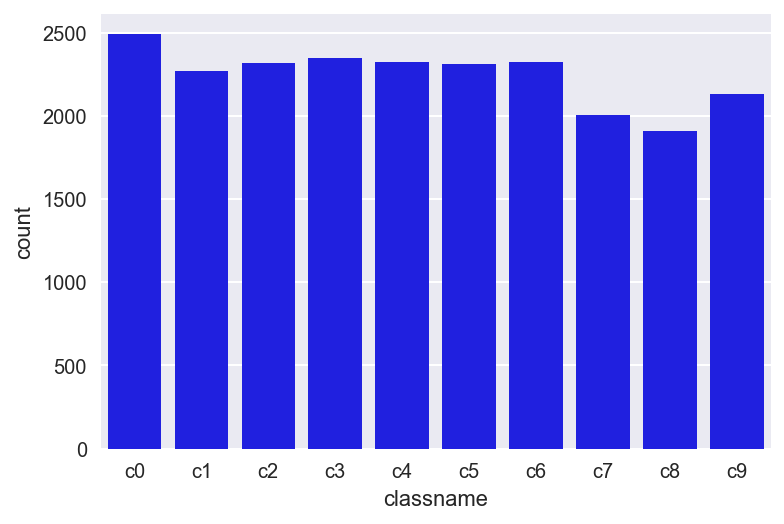

In [2]:
sns.set(style="darkgrid")
ax = sns.countplot(x='classname', data=driver_image_list, color='blue')

每个司机拥有的图像数量。

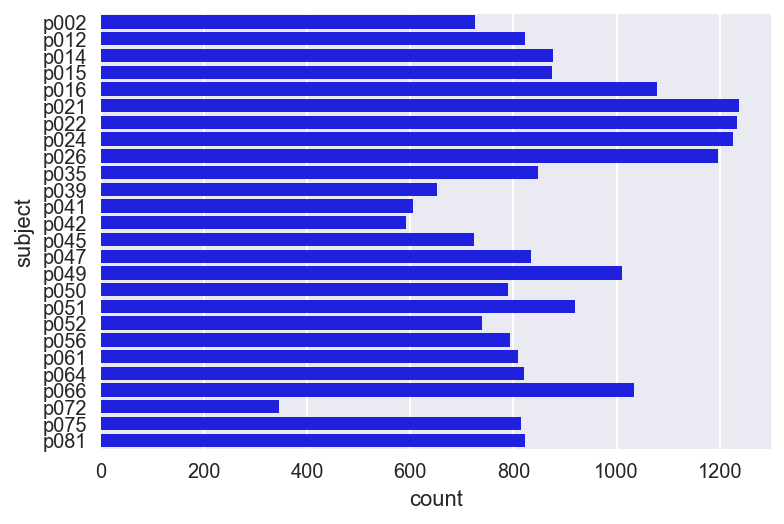

In [15]:
ax = sns.countplot(y='subject', data=driver_image_list, color='blue')

每个司机在每个类别上的图像数量分布。

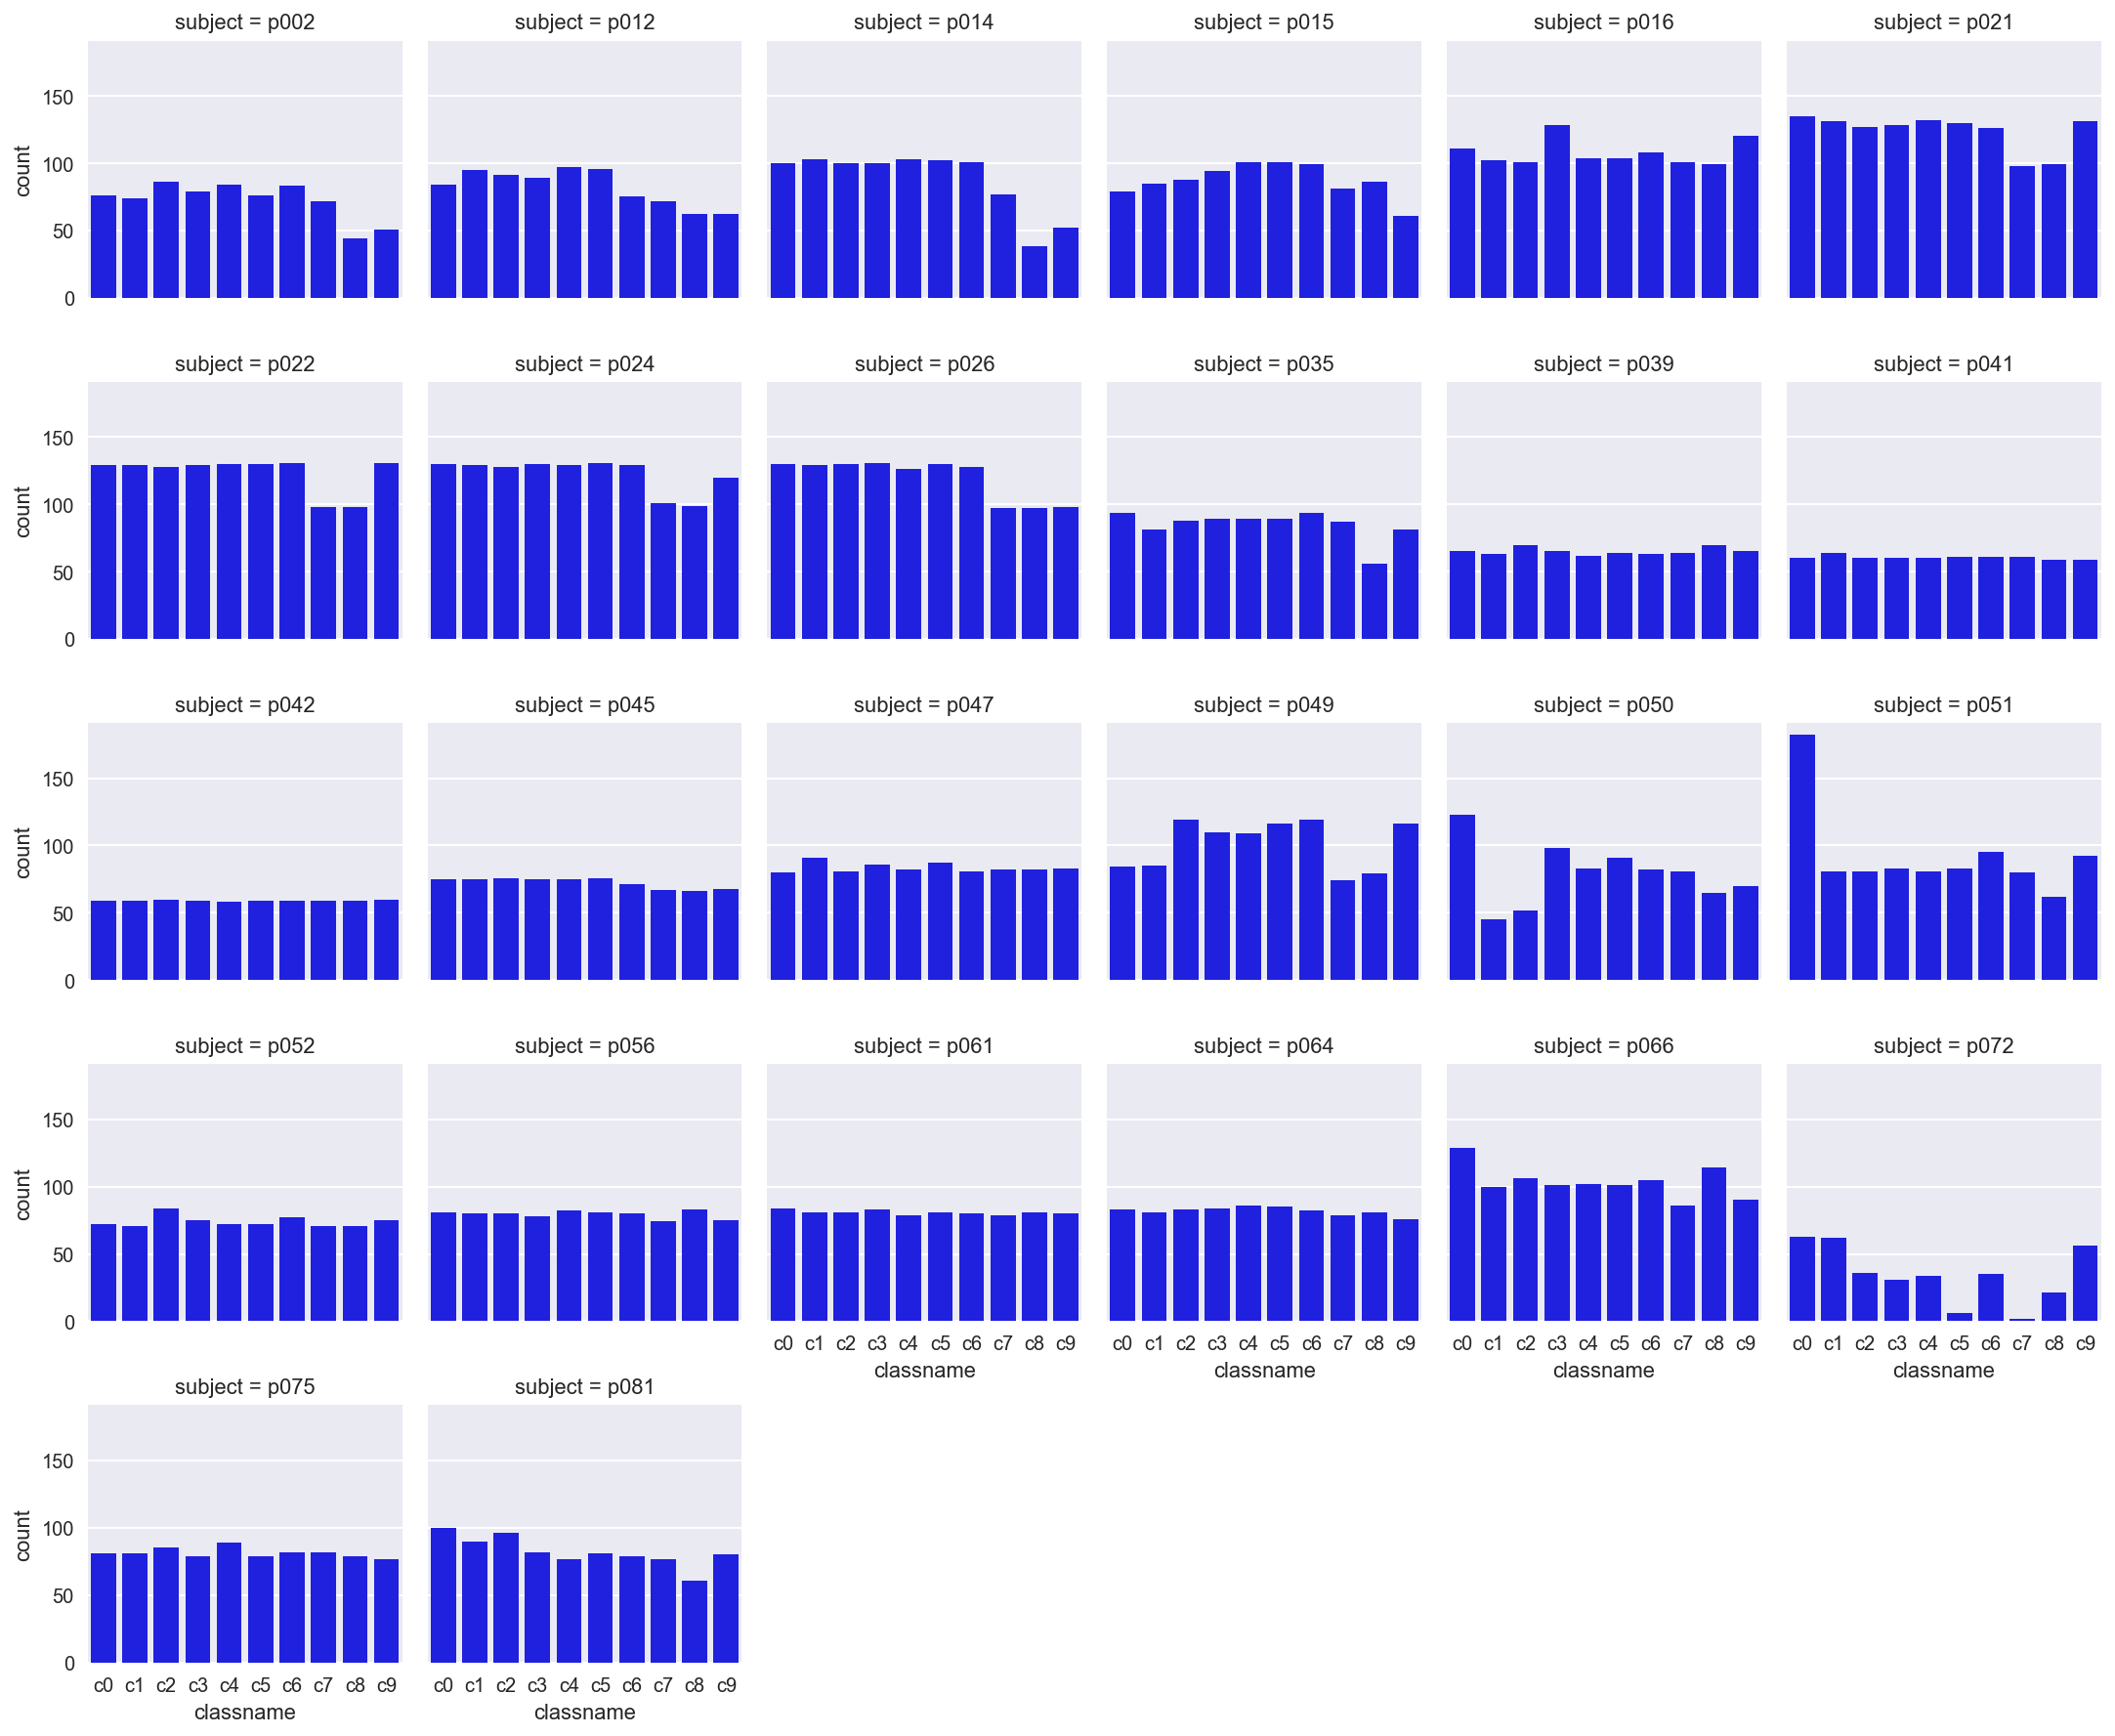

In [16]:
ax = sns.factorplot(x="classname", col='subject', col_wrap=6, data=driver_image_list, kind="count", size=2.5, color='blue')

### 二、数据预处理
解压图像压缩包

In [9]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')

In [17]:
zip_path = join(pardir, 'data', 'imgs.zip')

# 解压图像数据压缩包
if not isdir(driver_dataset_folder_path):
    with zipfile.ZipFile(zip_path) as zipfile:
        zipfile.extractall(driver_dataset_folder_path)
        zipfile.close()

查看单张图像文件。

The size of the image is (480, 640, 3):


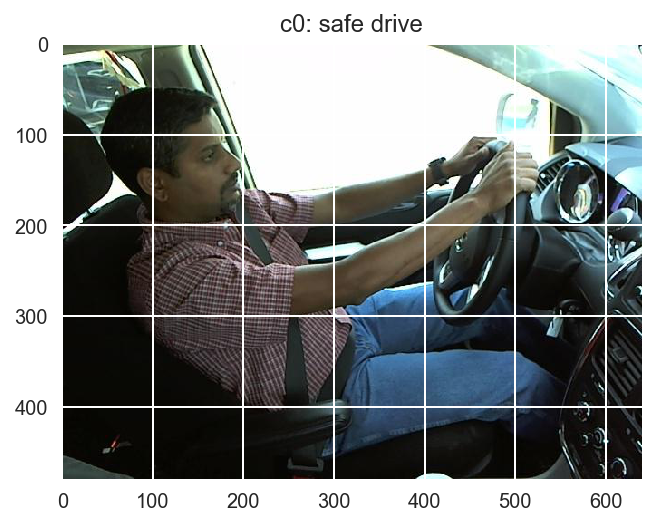

In [7]:
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')

# 示例图片
image_file = join(image_train_folder_path, 'c0', 'img_34.jpg')
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("The size of the image is {}:".format(image.shape))
#plt.axis('off')
plt.title("c0: safe drive")
plt.imshow(image)
plt.show()

#### 1.图像缩放

resize the size of the image to 224*224.
The size of the image is (224, 224, 3):


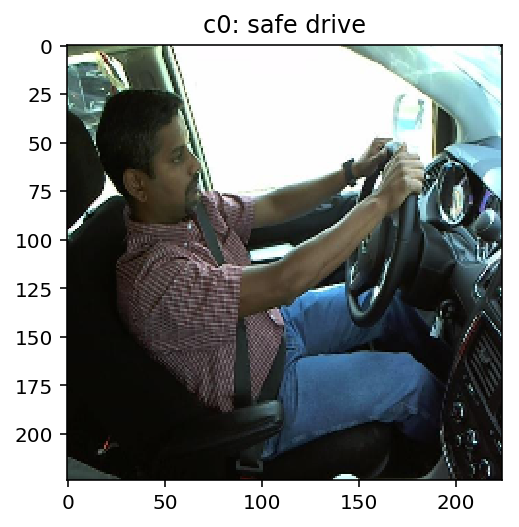

In [57]:
print("resize the size of the image to 224*224.")
resized = cv2.resize(image, (224, 224))
print("The size of the image is {}:".format(resized.shape))
#plt.axis('off')
plt.title("c0: safe drive")
plt.imshow(resized)
plt.show()

#### 2.图像旋转

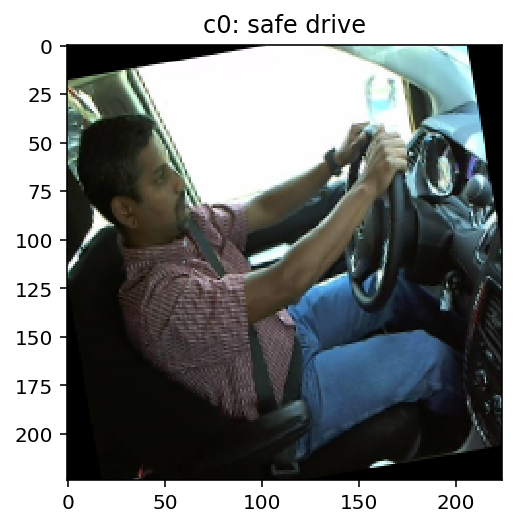

In [58]:
# getRotationMatrix2D(center, angle, scale) -> retval
M_rotate = cv2.getRotationMatrix2D((112, 112), 10, 1)
rotated = cv2.warpAffine(resized, M_rotate, (224, 224))

plt.title("c0: safe drive")
plt.imshow(rotated)
plt.show()

#### 3.图像平移

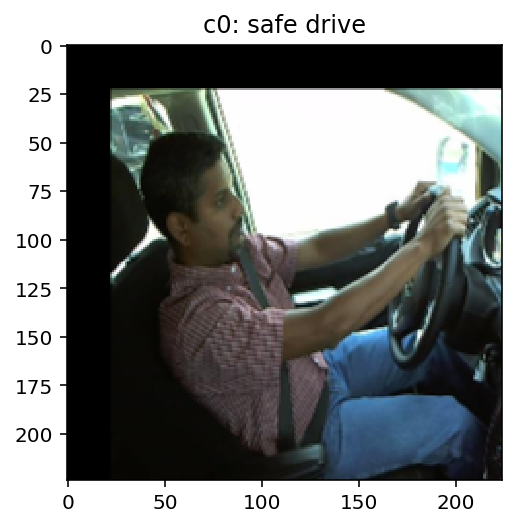

In [59]:
M_shift = np.array([[1, 0, 224*0.10], [0, 1, 224*0.10]], dtype=np.float32)
shifted = cv2.warpAffine(resized, M_shift, (224,224))

plt.title("c0: safe drive")
plt.imshow(shifted)
plt.show()

#### 4.去中心化

In [62]:
image = cv2.imread(image_file)
image = np.array(image, dtype=np.float32)

image = cv2.resize(image, (224, 224))

image[:,:,0] -= 103.939
image[:,:,1] -= 116.779
image[:,:,2] -= 123.68

### 二、划分训练集和验证集

In [10]:
valid_driver_id = ['p045', 'p056', 'p061']
driver_imgs_list = pd.read_csv(join(pardir, 'data', 'driver_imgs_list.csv'))
image_valid_folder_path = join(pardir, 'data', 'driver_dataset', 'valid')

for index, row in driver_imgs_list.iterrows():
    if row['subject'] in valid_driver_id:
        for i in range(10):
            image_path = join(driver_dataset_folder_path, 'train', 'c%s'%i)
            if os.path.exists(join(image_path, row['img'])):
                if not os.path.exists(join(image_valid_folder_path, 'c%s'%i)):
                    os.makedirs(join(image_valid_folder_path, 'c%s'%i))
                shutil.move(join(image_path, row['img']), join(image_valid_folder_path, 'c%s'%i, row['img']))